In [47]:
%pip install openai

In [48]:
import random
import json

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import numpy as np

from openai import OpenAI

from sklearn.metrics import confusion_matrix

In [4]:
data_df = pd.read_csv('https://huggingface.co/datasets/MohamedZayton/AMINA/resolve/main/BBC/BBC.csv')

In [5]:
data_df.isna().sum()

,0
Title,0
Article,0
Article_Class,0
Write_By,4773
Published Date,0


In [6]:
processed_df = data_df.copy()
processed_df['Write_By'] = processed_df['Write_By'].str.strip()

In [7]:
processed_df.dropna(subset=['Write_By'], inplace=True)

In [8]:
processed_df.groupby('Write_By').count()['Article'].values.max()

71

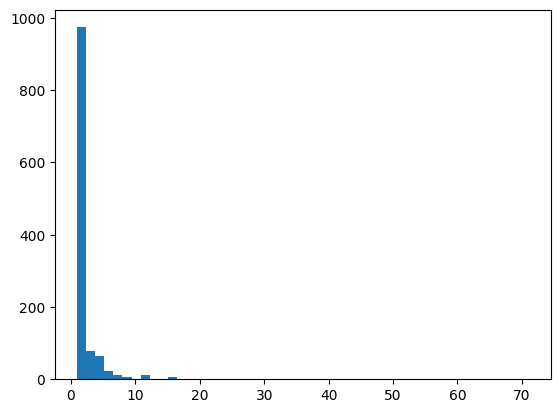

In [9]:
plt.hist(processed_df.groupby('Write_By').count()['Article'].values, bins=50)
plt.show()

In [10]:
n_top_authors = 10
top_authors = processed_df.groupby('Write_By').count()['Article'].sort_values(ascending=False).head(n_top_authors)
top_authors_names = top_authors.index.tolist()
top_authors

,Article
Write_By,
وليد بدران,71
قسم المتابعة الإعلامية,51
جيمس غالغر,42
ميشيل روبرتس,26
ديفيد غريتن,26
جيمس غالاغر,22
بول كيربي,20
حسام فازولا,16
زوي كلاينمان,15


In [11]:
top_authors_df = processed_df[processed_df['Write_By'].isin(top_authors.index)]

In [12]:
def get_authors_correct_and_incorrect_samples(author_name, n_correct_samples, n_incorrect_samples, df=top_authors_df):

    author_mask = df['Write_By'] == author_name
    author_df = df[author_mask]
    no_author_df = df[~author_mask]
    correct_samples = author_df.sample(n_correct_samples)['Article'].tolist()
    incorrect_samples = no_author_df.sample(n_incorrect_samples)['Article'].tolist()

    return correct_samples, incorrect_samples

## Initialzie the model

In [13]:
api_key = '<OPENAI-API-KEY-HERE>'

In [14]:
model = OpenAI(api_key=api_key)

## Testing the performance

In [15]:
def get_sample(author_name, n_prompt_example_articles, correct_prob=0.5):

    n_incorrect_articles = 1
    n_correct_articles = n_prompt_example_articles
    is_correct = random.random() <= correct_prob
    if is_correct:
        n_correct_articles += 1
        n_incorrect_articles = 0
    correct_samples, incorrect_samples = get_authors_correct_and_incorrect_samples(author_name, n_correct_articles, n_incorrect_articles)

    res = correct_samples+incorrect_samples

    prompt_examples = res[:-1]
    test_article = res[-1]

    return prompt_examples, test_article, is_correct

In [16]:
n_test_samples = 100
n_prompt_examples = 3
test_samples = []

for i in tqdm(range(n_test_samples)):

    author_name = random.choice(top_authors_names)
    test_samples.append(get_sample(author_name, n_prompt_examples))

100%|██████████| 100/100 [00:00<00:00, 667.59it/s]


In [50]:
SYSTEM_PROMPT = """
You are an expert text analyst specializing in authorship identification.
You will first be given several articles, all written by the same known author, to analyze their unique writing style, including linguistic patterns, tone, sentence structure, word choice, and overall style.
Afterward, you will be presented with an unknown article.
Your task is to critically compare the writing style of the unknown article with the known articles and determine if the unknown article was likely written by the same author.
Provide a clear justification for your conclusion based on stylistic similarities or differences.

Your final output must be in the following JSON format:

{{
  "verdict": true|false,
  "justification": "<Detailed explanation comparing the styles>"
}}
"""


PROMPT_TEMPLATE = """
AUTHOR NAME:
{author_name}

KNOWN ARTICLES:
{known_articles}

UNKNOWN ARTICLE:
{mystery_article}

JSON Answer:
"""


JSON_ONLY_PROMPT_TEMPLATE = """
Keep only the JSON part from this text and remove the rest.
If the JSON format is wrong, fix it.
Do not add anything else. I want to be able to parse it as a valid JSON.

Full Text:
{bad_text}

JSON ONLY TEXT:
"""

In [51]:
responses = []
ground_truth = []

for examples, test_article, is_correct in tqdm(test_samples):

    examples = [exp for exp in examples]

    prompt = PROMPT_TEMPLATE.format(
        author_name=author_name,
        known_articles='\n------------------------------'.join(examples),
        mystery_article=test_article
    )

    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": prompt}
    ]

    response = model.chat.completions.create(
        model="gpt-4o",
        messages=messages,
        temperature=0,
    )

    response = response.choices[0].message.content

    if response.startswith('```'):
        response = response[7:-3]

    try:
        response = json.loads(response)
    except json.JSONDecodeError:
        print('Bad JSON found.')
        json_fix_prompt = JSON_ONLY_PROMPT_TEMPLATE.format(bad_text=response)
        json_fix_messages = [
            {"role": "user", "content": json_fix_prompt}
        ]
        response = model.chat.completions.create(model="gpt-4o", messages=json_fix_messages, temperature=0,)
        response = response.choices[0].message.content
        response = json.loads(response)

    responses.append(response)
    ground_truth.append(is_correct)

100%|██████████| 100/100 [18:21<00:00, 11.01s/it]


In [52]:
response

{'verdict': False,
 'justification': 'Upon analyzing the known articles by بول كيربي, several stylistic elements are evident: a formal and informative tone, a focus on political and military events, and a detailed narrative structure that often includes direct quotes from officials and a chronological recounting of events. The language is precise, with a tendency to provide context and background information to enhance understanding. The sentence structure is complex, often employing compound and complex sentences to convey detailed information. In contrast, the unknown article on monkeypox, while maintaining a formal tone, diverges in several key aspects. It focuses on a health-related topic rather than political or military events, and the narrative is more exploratory and speculative, discussing potential outcomes and scientific perspectives. The language is more accessible, with simpler sentence structures and a focus on explaining scientific concepts to a general audience. Additio

In [53]:
predicted = [res['verdict'] for res in tqdm(responses)]

100%|██████████| 100/100 [00:00<00:00, 108100.62it/s]


In [54]:
ground_truth = np.array(ground_truth)
predicted = np.array(predicted)

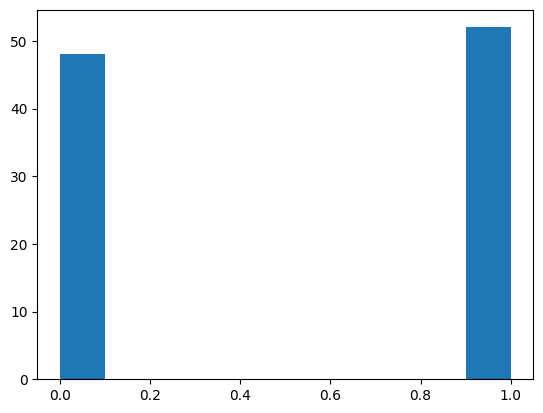

In [55]:
plt.hist(ground_truth.astype(int))
plt.show()

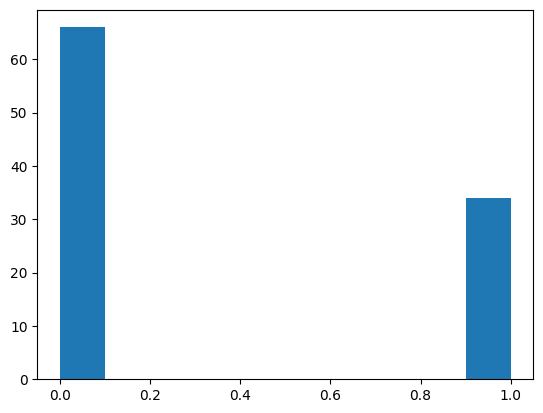

In [56]:
plt.hist(predicted.astype(int))
plt.show()

In [57]:
(predicted == ground_truth).sum()/len(predicted)

0.72

In [58]:
confusion_matrix(ground_truth, predicted)

array([[43,  5],
       [23, 29]])